In [8]:
import mne
import numpy as np
import os

# Define the path to the dataset and the output directory
gdf_path = 'data/BCICIV_2a_gdf/A01T.gdf'
output_dir = 'data/BCICIV_2a_gdf/sub1_segment_QC'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Step 1: Load the BCI-IV 2a dataset
raw = mne.io.read_raw_gdf(gdf_path, preload=True)

# Remove the last three channels (EOG-left, EOG-central, and EOG-right)
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

# Step 2: Extract epochs for each class using provided event IDs
event_id = {'769': 5, '770': 6, '771': 7, '772': 8}
events, _ = mne.events_from_annotations(raw, event_id=event_id)
tmin, tmax = 1.5, 6  # 4.5 seconds epochs starting at 1.5s

# Creating epochs for each class
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=True)
data = epochs.get_data()  # shape is (n_epochs, n_channels, n_times)

# Standardize each channel
data = (data - data.mean(axis=2, keepdims=True)) / data.std(axis=2, keepdims=True)

# Step 3: Save each epoch as a matrix of shape (22, 1125) in different subfolders
for i, epoch_data in enumerate(data):
    # Adjust labels to start from 0 by subtracting 7 from each label
    label = epochs.events[i, -1] - 4
    # Create subfolder if it doesn't exist
    class_output_dir = os.path.join(output_dir, f'class_{label}')
    os.makedirs(class_output_dir, exist_ok=True)
    file_path = os.path.join(class_output_dir, f'sub_epoch_{i+1}.npy')
    np.save(file_path, epoch_data)

print(f'Saved {len(data)} epochs to {output_dir}')


Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Saved 287 epochs to data/BCICIV_2a_gdf/sub1_segment_QC


/tmp/ipykernel_10084/599132063.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # shape is (n_epochs, n_channels, n_times)


In [ ]:
import mne
import numpy as np
import os

# Define the path to the dataset and the output directory
gdf_dir = '/home/jovyan/BCICIV_2a_gdf'
output_dir = '/home/jovyan/BCICIV_2a_gdf/epoch_finalvol2'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# List of subject files
subjects = ['A01T.gdf', 'A02T.gdf', 'A03T.gdf', 'A04T.gdf', 'A05T.gdf', 'A06T.gdf', 'A07T.gdf', 'A08T.gdf', 'A09T.gdf']

# Event IDs for the classes
event_id = {'769': 7, '770': 8, '771': 9, '772': 10}
tmin, tmax = 1.5, 6  # 4.5 seconds epochs starting at 1.5s

for subject in subjects:
    # Define the path to the subject's GDF file
    gdf_path = os.path.join(gdf_dir, subject)
    
    # Load the BCI-IV 2a dataset
    raw = mne.io.read_raw_gdf(gdf_path, preload=True)

    # Remove the last three channels (EOG-left, EOG-central, and EOG-right)
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

    # Extract epochs for each class using provided event IDs
    events, _ = mne.events_from_annotations(raw, event_id=event_id)

    # Creating epochs for each class
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=True)
    data = epochs.get_data()  # shape is (n_epochs, n_channels, n_times)

    # Standardize each channel
    data = (data - data.mean(axis=2, keepdims=True)) / data.std(axis=2, keepdims=True)

    # Step 3: Save each epoch as a matrix of shape (22, 1125) in different subfolders
    for i, epoch_data in enumerate(data):
        # Adjust labels to start from 0 by subtracting 5 from each label
        label = epochs.events[i, -1] - 5
        # Create subfolder if it doesn't exist
        class_output_dir = os.path.join(output_dir, f'class_{label}')
        os.makedirs(class_output_dir, exist_ok=True)
        file_path = os.path.join(class_output_dir, f'{subject[:-4]}_epoch_{i+1}.npy')
        np.save(file_path, epoch_data)

    print(f'Saved {len(data)} epochs for {subject} to {output_dir}')

print("Processing complete for all subjects.")


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load and preprocess data
def load_data(data_dir):
    data = []
    labels = []
    for label in range(4):
        class_dir = os.path.join(data_dir, f'class_{label}')
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            if os.path.isfile(file_path) and file_path.endswith('.npy'):
                epoch_data = np.load(file_path)
                data.append(epoch_data)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

# Define the path to the processed data
processed_data_dir = 'data/BCICIV_2a_gdf/processed_epoch_final1'
data, labels = load_data(processed_data_dir)

# Split data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
test_data = scaler.transform(test_data.reshape(-1, test_data.shape[-1])).reshape(test_data.shape)

# Data Augmentation (e.g., time-shifting)
def augment_data(data):
    augmented_data = []
    for epoch in data:
        shift = np.random.randint(epoch.shape[1] // 10)
        if np.random.rand() > 0.5:
            epoch = np.roll(epoch, shift, axis=1)
        else:
            epoch = np.roll(epoch, -shift, axis=1)
        augmented_data.append(epoch)
    return np.array(augmented_data)

train_data = augment_data(train_data)

# Define model hyperparameters
C = train_data.shape[1]  # Number of channels
T = train_data.shape[2]  # Number of samples
F1 = 32  # Number of temporal filters in EEGnet
F2 = 64  # Number of pointwise filters in EEGnet
D = 4  # Depth multiplier
KE = 64  # Kernel size in EEGnet first convolution
KT = 32  # Kernel size in TCN block
pe = 0.4  # Dropout rate in EEGnet
pt = 0.4  # Dropout rate in TCN block
FT = 32  # Filters in TCN block

# Define the model
def create_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # EEGNet Block
    x = tf.keras.layers.Conv2D(F1, (1, KE), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='C1')(inputs)
    x = tf.keras.layers.BatchNormalization(name='BN1')(x)
    x = tf.keras.layers.DepthwiseConv2D((C, 1), depth_multiplier=D, padding='valid', depthwise_constraint=tf.keras.constraints.max_norm(1.), name='C2')(x)
    x = tf.keras.layers.BatchNormalization(name='BN2')(x)
    x = tf.keras.layers.ELU(name='A1')(x)
    x = tf.keras.layers.AveragePooling2D((1, 8), name='P1')(x)
    x = tf.keras.layers.Dropout(pe, name='D1')(x)
    x = tf.keras.layers.SeparableConv2D(F2, (1, 16), padding='same', name='C3')(x)
    x = tf.keras.layers.BatchNormalization(name='B2')(x)
    x = tf.keras.layers.ELU(name='A2')(x)
    x = tf.keras.layers.AveragePooling2D((1, 8), name='P2')(x)
    x = tf.keras.layers.Dropout(pe, name='D2')(x)

    # Temporal Convolutional Block
    tcn = tf.keras.layers.Conv2D(FT, (1, KT), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='TC')(x)
    tcn = tf.keras.layers.Dropout(pt)(tcn)
    tcn = tf.keras.layers.ELU()(tcn)

    # Concatenation
    x = tf.keras.layers.Concatenate(name='CON1')([x, tcn])

    # Fully Connected Layers
    fc1 = tf.keras.layers.Flatten(name='FC1')(x)
    fc2 = tf.keras.layers.Flatten(name='FC2')(x)
    x = tf.keras.layers.Concatenate(name='CON2')([fc1, fc2])
    x = tf.keras.layers.Dense(256, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.01), kernel_constraint=tf.keras.constraints.max_norm(0.25))(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Add another dropout layer
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Initialize and compile the model
input_shape = (C, T, 1)
model = create_model(input_shape)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))

# Train the model
num_epochs = 200
batch_size = 32
history = model.fit(train_data, train_labels, epochs=num_epochs, batch_size=batch_size,
                    validation_split=0.2, callbacks=[lr_scheduler, early_stopping],
                    class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# Make predictions
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print(f'Test Accuracy (calculated): {accuracy * 100:.2f}%')

# Calculate Cohen's kappa score
kappa_score = cohen_kappa_score(test_labels, predicted_labels)
print(f"Cohen's κ-score: {kappa_score:.2f}")

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Print the number of parameters
num_params = model.count_params()
print(f'Number of parameters: {num_params}')


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load and preprocess data
def load_data(data_dir):
    data = []
    labels = []
    for label in range(4):
        class_dir = os.path.join(data_dir, f'class_{label}')
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            if os.path.isfile(file_path) and file_path.endswith('.npy'):
                epoch_data = np.load(file_path)
                data.append(epoch_data)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

# Define the path to the processed data
processed_data_dir = '/home/jovyan/BCICIV_2a_gdf/epoch_finalvol2'
data, labels = load_data(processed_data_dir)

# Split data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
test_data = scaler.transform(test_data.reshape(-1, test_data.shape[-1])).reshape(test_data.shape)

# Data Augmentation (e.g., time-shifting)
def augment_data(data):
    augmented_data = []
    for epoch in data:
        shift = np.random.randint(epoch.shape[1] // 10)
        if np.random.rand() > 0.5:
            epoch = np.roll(epoch, shift, axis=1)
        else:
            epoch = np.roll(epoch, -shift, axis=1)
        augmented_data.append(epoch)
    return np.array(augmented_data)

train_data = augment_data(train_data)

# Define model hyperparameters
C = train_data.shape[1]  # Number of channels
T = train_data.shape[2]  # Number of samples
F1 = 32  # Number of temporal filters in EEGnet
F2 = 64  # Number of pointwise filters in EEGnet
D = 4  # Depth multiplier
KE = 64  # Kernel size in EEGnet first convolution
KT = 32  # Kernel size in TCN block
pe = 0.4  # Dropout rate in EEGnet
pt = 0.4  # Dropout rate in TCN block
FT = 32  # Filters in TCN block

# Define the model
def create_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # EEGNet Block
    x = tf.keras.layers.Conv2D(F1, (1, KE), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='C1')(inputs)
    x = tf.keras.layers.BatchNormalization(name='BN1')(x)
    x = tf.keras.layers.DepthwiseConv2D((C, 1), depth_multiplier=D, padding='valid', depthwise_constraint=tf.keras.constraints.max_norm(1.), name='C2')(x)
    x = tf.keras.layers.BatchNormalization(name='BN2')(x)
    x = tf.keras.layers.ELU(name='A1')(x)
    x = tf.keras.layers.AveragePooling2D((1, 8), name='P1')(x)
    x = tf.keras.layers.Dropout(pe, name='D1')(x)
    x = tf.keras.layers.SeparableConv2D(F2, (1, 16), padding='same', name='C3')(x)
    x = tf.keras.layers.BatchNormalization(name='B2')(x)
    x = tf.keras.layers.ELU(name='A2')(x)
    x = tf.keras.layers.AveragePooling2D((1, 8), name='P2')(x)
    x = tf.keras.layers.Dropout(pe, name='D2')(x)

    # Temporal Convolutional Block
    tcn = tf.keras.layers.Conv2D(FT, (1, KT), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='TC')(x)
    tcn = tf.keras.layers.Dropout(pt)(tcn)
    tcn = tf.keras.layers.ELU()(tcn)

    # Concatenation
    x = tf.keras.layers.Concatenate(name='CON1')([x, tcn])

    # Fully Connected Layers
    fc1 = tf.keras.layers.Flatten(name='FC1')(x)
    fc2 = tf.keras.layers.Flatten(name='FC2')(x)
    x = tf.keras.layers.Concatenate(name='CON2')([fc1, fc2])
    x = tf.keras.layers.Dense(256, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.01), kernel_constraint=tf.keras.constraints.max_norm(0.25))(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Add another dropout layer
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Initialize and compile the model
input_shape = (C, T, 1)
model = create_model(input_shape)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))

# Train the model
num_epochs = 200
batch_size = 32
history = model.fit(train_data, train_labels, epochs=num_epochs, batch_size=batch_size,
                    validation_split=0.2, callbacks=[lr_scheduler, early_stopping],
                    class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# Make predictions
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print(f'Test Accuracy (calculated): {accuracy * 100:.2f}%')

# Calculate Cohen's kappa score
kappa_score = cohen_kappa_score(test_labels, predicted_labels)
print(f"Cohen's κ-score: {kappa_score:.2f}")

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Print the number of parameters
num_params = model.count_params()
print(f'Number of parameters: {num_params}')


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
def load_data(data_dir):
    data = []
    labels = []
    for label in range(2):  # Only load classes 0 and 1
        class_dir = os.path.join(data_dir, f'class_{label}')
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            if os.path.isfile(file_path) and file_path.endswith('.npy'):
                epoch_data = np.load(file_path)
                data.append(epoch_data)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

# Define the path to the processed data
processed_data_dir = '/home/jovyan/BCICIV_2a_gdf/epoch_finalvol2'
data, labels = load_data(processed_data_dir)

# Split data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
test_data = scaler.transform(test_data.reshape(-1, test_data.shape[-1])).reshape(test_data.shape)

# Data Augmentation (e.g., time-shifting)
def augment_data(data):
    augmented_data = []
    for epoch in data:
        shift = np.random.randint(epoch.shape[1] // 10)
        if np.random.rand() > 0.5:
            epoch = np.roll(epoch, shift, axis=1)
        else:
            epoch = np.roll(epoch, -shift, axis=1)
        augmented_data.append(epoch)
    return np.array(augmented_data)

train_data = augment_data(train_data)

# Define model hyperparameters
C = train_data.shape[1]  # Number of channels
T = train_data.shape[2]  # Number of samples
F1 = 32  # Number of temporal filters in EEGnet
F2 = 64  # Number of pointwise filters in EEGnet
D = 4  # Depth multiplier
KE = 64  # Kernel size in EEGnet first convolution
KT = 32  # Kernel size in TCN block
pe = 0.4  # Dropout rate in EEGnet
pt = 0.4  # Dropout rate in TCN block
FT = 32  # Filters in TCN block

# Define the model
def create_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # EEGNet Block
    x = tf.keras.layers.Conv2D(F1, (1, KE), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='C1')(inputs)
    x = tf.keras.layers.BatchNormalization(name='BN1')(x)
    x = tf.keras.layers.DepthwiseConv2D((C, 1), depth_multiplier=D, padding='valid', depthwise_constraint=tf.keras.constraints.max_norm(1.), name='C2')(x)
    x = tf.keras.layers.BatchNormalization(name='BN2')(x)
    x = tf.keras.layers.ELU(name='A1')(x)
    x = tf.keras.layers.AveragePooling2D((1, 8), name='P1')(x)
    x = tf.keras.layers.Dropout(pe, name='D1')(x)
    x = tf.keras.layers.SeparableConv2D(F2, (1, 16), padding='same', name='C3')(x)
    x = tf.keras.layers.BatchNormalization(name='B2')(x)
    x = tf.keras.layers.ELU(name='A2')(x)
    x = tf.keras.layers.AveragePooling2D((1, 8), name='P2')(x)
    x = tf.keras.layers.Dropout(pe, name='D2')(x)

    # Temporal Convolutional Block
    tcn = tf.keras.layers.Conv2D(FT, (1, KT), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='TC')(x)
    tcn = tf.keras.layers.Dropout(pt)(tcn)
    tcn = tf.keras.layers.ELU()(tcn)

    # Concatenation
    x = tf.keras.layers.Concatenate(name='CON1')([x, tcn])

    # Fully Connected Layers
    fc1 = tf.keras.layers.Flatten(name='FC1')(x)
    x = tf.keras.layers.Dense(256, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.01), kernel_constraint=tf.keras.constraints.max_norm(0.25))(fc1)
    x = tf.keras.layers.Dropout(0.5)(x)  # Add another dropout layer
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)  # Change output layer to 2 classes

    model = tf.keras.Model(inputs, outputs)
    return model

# Initialize and compile the model
input_shape = (C, T, 1)
model = create_model(input_shape)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))

# Train the model
num_epochs = 200
batch_size = 32
history = model.fit(train_data, train_labels, epochs=num_epochs, batch_size=batch_size,
                    validation_split=0.2, callbacks=[lr_scheduler, early_stopping],
                    class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# Make predictions
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(test_labels, predicted_labels)
kappa_score = cohen_kappa_score(test_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')

print(f'Test Accuracy (calculated): {accuracy * 100:.2f}%')
print(f"Cohen's κ-score: {kappa_score:.2f}")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Print the number of parameters
num_params = model.count_params()
print(f'Number of parameters: {num_params}')

# Plot learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
 import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
def load_data(data_dir):
    data = []
    labels = []
    for label in range(2):  # Only load classes 0 and 1
        class_dir = os.path.join(data_dir, f'class_{label}')
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            if os.path.isfile(file_path) and file_path.endswith('.npy'):
                epoch_data = np.load(file_path)
                data.append(epoch_data)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

# Define the path to the processed data
processed_data_dir = '/home/jovyan/BCICIV_2a_gdf/epoch_finalvol2'
data, labels = load_data(processed_data_dir)

# Split data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
test_data = scaler.transform(test_data.reshape(-1, test_data.shape[-1])).reshape(test_data.shape)

# Define model hyperparameters
C = train_data.shape[1]  # Number of channels
T = train_data.shape[2]  # Number of samples
F1 = 32  # Number of temporal filters in EEGnet
F2 = 64  # Number of pointwise filters in EEGnet
D = 4  # Depth multiplier
KE = 64  # Kernel size in EEGnet first convolution
KT = 32  # Kernel size in TCN block
pe = 0.4  # Dropout rate in EEGnet
pt = 0.4  # Dropout rate in TCN block
FT = 32  # Filters in TCN block

# Define the model
def create_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # EEGNet Block
    x = tf.keras.layers.Conv2D(F1, (1, KE), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='C1')(inputs)
    x = tf.keras.layers.BatchNormalization(name='BN1')(x)
    x = tf.keras.layers.DepthwiseConv2D((C, 1), depth_multiplier=D, padding='valid', depthwise_constraint=tf.keras.constraints.max_norm(1.), name='C2')(x)
    x = tf.keras.layers.BatchNormalization(name='BN2')(x)
    x = tf.keras.layers.ELU(name='A1')(x)
    x = tf.keras.layers.AveragePooling2D((1, 8), name='P1')(x)
    x = tf.keras.layers.Dropout(pe, name='D1')(x)
    x = tf.keras.layers.SeparableConv2D(F2, (1, 16), padding='same', name='C3')(x)
    x = tf.keras.layers.BatchNormalization(name='B2')(x)
    x = tf.keras.layers.ELU(name='A2')(x)
    x = tf.keras.layers.AveragePooling2D((1, 8), name='P2')(x)
    x = tf.keras.layers.Dropout(pe, name='D2')(x)

    # Temporal Convolutional Block
    tcn = tf.keras.layers.Conv2D(FT, (1, KT), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='TC')(x)
    tcn = tf.keras.layers.Dropout(pt)(tcn)
    tcn = tf.keras.layers.ELU()(tcn)

    # Concatenation
    x = tf.keras.layers.Concatenate(name='CON1')([x, tcn])

    # Fully Connected Layers
    fc1 = tf.keras.layers.Flatten(name='FC1')(x)
    x = tf.keras.layers.Dense(256, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.01), kernel_constraint=tf.keras.constraints.max_norm(0.25))(fc1)
    x = tf.keras.layers.Dropout(0.5)(x)  # Add another dropout layer
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)  # Change output layer to 2 classes

    model = tf.keras.Model(inputs, outputs)
    return model

# Initialize and compile the model
input_shape = (C, T, 1)
model = create_model(input_shape)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))

# Train the model
num_epochs = 200
batch_size = 32
history = model.fit(train_data, train_labels, epochs=num_epochs, batch_size=batch_size,
                    validation_split=0.2, callbacks=[lr_scheduler, early_stopping],
                    class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# Make predictions
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(test_labels, predicted_labels)
kappa_score = cohen_kappa_score(test_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')

print(f'Test Accuracy (calculated): {accuracy * 100:.2f}%')
print(f"Cohen's κ-score: {kappa_score:.2f}")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Print the number of parameters
num_params = model.count_params()
print(f'Number of parameters: {num_params}')

# Plot learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
def load_data(data_dir):
    data = []
    labels = []
    for label in range(2):  # Only load classes 0 and 1
        class_dir = os.path.join(data_dir, f'class_{label}')
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            if os.path.isfile(file_path) and file_path.endswith('.npy'):
                epoch_data = np.load(file_path)
                data.append(epoch_data)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

# Define the path to the processed data
processed_data_dir = '/home/jovyan/BCICIV_2a_gdf/epoch_finalvol2'
data, labels = load_data(processed_data_dir)

# Split data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
test_data = scaler.transform(test_data.reshape(-1, test_data.shape[-1])).reshape(test_data.shape)

# Data Augmentation (e.g., time-shifting, noise, jitter)
def augment_data(data):
    augmented_data = []
    for epoch in data:
        # Time-shifting
        shift = np.random.randint(epoch.shape[1] // 10)
        if np.random.rand() > 0.5:
            epoch = np.roll(epoch, shift, axis=1)
        else:
            epoch = np.roll(epoch, -shift, axis=1)
        
        # Add noise
        noise = np.random.normal(0, 0.1, epoch.shape)
        epoch += noise
        
        # Jittering
        jitter = np.random.normal(0, 0.01, epoch.shape)
        epoch += jitter
        
        augmented_data.append(epoch)
    return np.array(augmented_data)

train_data = augment_data(train_data)

# Define model hyperparameters
C = train_data.shape[1]  # Number of channels
T = train_data.shape[2]  # Number of samples
F1 = 32  # Number of temporal filters in EEGnet
F2 = 64  # Number of pointwise filters in EEGnet
D = 4  # Depth multiplier
KE = 64  # Kernel size in EEGnet first convolution
KT = 32  # Kernel size in TCN block
pe = 0.4  # Dropout rate in EEGnet
pt = 0.4  # Dropout rate in TCN block
FT = 32  # Filters in TCN block

# Define the model
def create_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # EEGNet Block
    x = tf.keras.layers.Conv2D(F1, (1, KE), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='C1')(inputs)
    x = tf.keras.layers.BatchNormalization(name='BN1')(x)
    x = tf.keras.layers.DepthwiseConv2D((C, 1), depth_multiplier=D, padding='valid', depthwise_constraint=tf.keras.constraints.max_norm(1.), name='C2')(x)
    x = tf.keras.layers.BatchNormalization(name='BN2')(x)
    x = tf.keras.layers.ELU(name='A1')(x)
    x = tf.keras.layers.AveragePooling2D((1, 8), name='P1')(x)
    x = tf.keras.layers.Dropout(pe, name='D1')(x)
    x = tf.keras.layers.SeparableConv2D(F2, (1, 16), padding='same', name='C3')(x)
    x = tf.keras.layers.BatchNormalization(name='B2')(x)
    x = tf.keras.layers.ELU(name='A2')(x)
    x = tf.keras.layers.AveragePooling2D((1, 8), name='P2')(x)
    x = tf.keras.layers.Dropout(pe, name='D2')(x)

    # Temporal Convolutional Block
    tcn = tf.keras.layers.Conv2D(FT, (1, KT), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='TC')(x)
    tcn = tf.keras.layers.Dropout(pt)(tcn)
    tcn = tf.keras.layers.ELU()(tcn)

    # Concatenation
    x = tf.keras.layers.Concatenate(name='CON1')([x, tcn])

    # Fully Connected Layers
    fc1 = tf.keras.layers.Flatten(name='FC1')(x)
    x = tf.keras.layers.Dense(256, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.01), kernel_constraint=tf.keras.constraints.max_norm(0.25))(fc1)
    x = tf.keras.layers.Dropout(0.5)(x)  # Add another dropout layer
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)  # Change output layer to 2 classes

    model = tf.keras.Model(inputs, outputs)
    return model

# Initialize and compile the model
input_shape = (C, T, 1)
model = create_model(input_shape)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))

# Train the model
num_epochs = 200
batch_size = 32
history = model.fit(train_data, train_labels, epochs=num_epochs, batch_size=batch_size,
                    validation_split=0.2, callbacks=[lr_scheduler, early_stopping, model_checkpoint],
                    class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# Make predictions
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(test_labels, predicted_labels)
kappa_score = cohen_kappa_score(test_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')

print(f'Test Accuracy (calculated): {accuracy * 100:.2f}%')
print(f"Cohen's κ-score: {kappa_score:.2f}")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Print the number of parameters
num_params = model.count_params()
print(f'Number of parameters: {num_params}')

# Plot learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [12]:
import numpy as np
import os
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Define the path to the dataset
base_path = 'data/BCICIV_2a_gdf/sub1_segment_QC'

# Load data from the subfolders
X, y = [], []
class_folders = ['class_1', 'class_2', 'class_3', 'class_4']
class_labels = {folder: i for i, folder in enumerate(class_folders)}

for class_folder in class_folders:
    folder_path = os.path.join(base_path, class_folder)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(folder_path, file_name)
            epoch_data = np.load(file_path)
            X.append(epoch_data)
            y.append(class_labels[class_folder])

X = np.array(X)
y = np.array(y)

# Step 1: Preprocessing (Filtering and WPD)
def preprocess_signal(signal, wavelet='db4', level=8):
    # Apply Wavelet Packet Decomposition
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric', maxlevel=level)
    nodes = wp.get_level(level, order='natural')
    features = np.array([node.data for node in nodes]).flatten()
    return features

X_preprocessed = np.array([preprocess_signal(epoch) for epoch in X])

# Step 2: Feature Extraction (already done in preprocessing with WPD)
X_features = X_preprocessed

# Standardize the data
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_features_scaled)

# Print the shape of the feature matrix after PCA
print(f"Shape of X_pca: {X_pca.shape}")

# Step 3: Feature Selection using Quantum Genetic Algorithm (QGA)
def qga_feature_selection(X, y, num_generations=100, population_size=50, num_features=20):
    # Placeholder function for QGA-based feature selection
    # This function should return the indices of the selected features
    # Here, we just randomly select features as a placeholder
    np.random.seed(42)
    selected_indices = np.random.choice(X.shape[1], num_features, replace=False)
    return selected_indices

# Apply QGA for feature selection
selected_features_indices = qga_feature_selection(X_pca, y, num_features=20)
X_selected = X_pca[:, selected_features_indices]

# Print the shape of the feature matrix after feature selection
print(f"Shape of X_selected: {X_selected.shape}")

# Example train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Step 4: Classification using classical machine learning algorithms

# SVM Classification
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate SVM performance
accuracy_svm = accuracy_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)

print("SVM Metrics:")
print(f"Accuracy: {accuracy_svm}")
print(f"Recall: {recall_svm}")
print(f"Confusion Matrix:\n{confusion_matrix_svm}")

# Random Forest Classification
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate Random Forest performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_rf}")
print(f"Recall: {recall_rf}")
print(f"Confusion Matrix:\n{confusion_matrix_rf}")

# Optionally, print classification report for more detailed metrics
print("Classification Report for SVM:")
print(classification_report(y_test, y_pred_svm))

print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))


Shape of X_pca: (287, 100)
Shape of X_selected: (287, 20)
SVM Metrics:
Accuracy: 0.2413793103448276
Recall: 0.2413793103448276
Confusion Matrix:
[[4 4 2 3]
 [2 2 1 9]
 [7 4 6 4]
 [2 5 1 2]]
Random Forest Metrics:
Accuracy: 0.1724137931034483
Recall: 0.1724137931034483
Confusion Matrix:
[[2 7 1 3]
 [3 2 0 9]
 [4 7 4 6]
 [2 5 1 2]]
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.27      0.31      0.29        13
           1       0.13      0.14      0.14        14
           2       0.60      0.29      0.39        21
           3       0.11      0.20      0.14        10

    accuracy                           0.24        58
   macro avg       0.28      0.23      0.24        58
weighted avg       0.33      0.24      0.26        58

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.18      0.15      0.17        13
           1       0.10      0.14      0.11        1

In [ ]:
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Define the path to the dataset
base_path = 'data/BCICIV_2a_gdf/sub1_segment_QC'

# Load data from the subfolders
X, y = [], []
class_folders = ['class_1', 'class_2', 'class_3', 'class_4']
class_labels = {folder: i for i, folder in enumerate(class_folders)}

for class_folder in class_folders:
    folder_path = os.path.join(base_path, class_folder)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(folder_path, file_name)
            epoch_data = np.load(file_path)
            X.append(epoch_data)
            y.append(class_labels[class_folder])

X = np.array(X)
y = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Flatten the data for feature selection
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Feature selection using Quantum Genetic Algorithm (simplified version)
def quantum_genetic_algorithm(X, y, num_generations=10, population_size=20, num_features=10):
    # Initialize population with random feature subsets
    population = [np.random.choice([0, 1], size=X.shape[1]) for _ in range(population_size)]

    def fitness(individual):
        selected_features = np.where(individual == 1)[0]
        if len(selected_features) == 0:
            return 0
        X_selected = X[:, selected_features]
        X_train_selected, X_val_selected, y_train_selected, y_val_selected = train_test_split(X_selected, y, test_size=0.2, random_state=42)
        
        feature_map = ZZFeatureMap(feature_dimension=X_selected.shape[1], reps=2)
        kernel = FidelityQuantumKernel(feature_map=feature_map)
        qsvc = QSVC(quantum_kernel=kernel)

        qsvc.fit(X_train_selected, y_train_selected)
        return qsvc.score(X_val_selected, y_val_selected)

    for generation in range(num_generations):
        # Calculate fitness for each individual
        fitness_scores = np.array([fitness(individual) for individual in population])

        # Select individuals based on fitness scores
        selected_population = population[np.argsort(fitness_scores)[-population_size//2:]]

        # Create next generation
        next_population = []
        for i in range(population_size):
            parent1 = random.choice(selected_population)
            parent2 = random.choice(selected_population)
            crossover_point = random.randint(0, len(parent1) - 1)
            child = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
            mutation_point = random.randint(0, len(child) - 1)
            child[mutation_point] = 1 - child[mutation_point]
            next_population.append(child)
        
        population = next_population

    # Select the best individual
    best_individual = population[np.argmax([fitness(individual) for individual in population])]
    selected_features = np.where(best_individual == 1)[0]
    return selected_features

selected_features = quantum_genetic_algorithm(X_train_flat, y_train)
X_train_selected = X_train_flat[:, selected_features]
X_test_selected = X_test_flat[:, selected_features]

# Standardize the data
scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

# Train and evaluate the QSVM model
feature_map = ZZFeatureMap(feature_dimension=X_train_selected.shape[1], reps=2)
kernel = FidelityQuantumKernel(feature_map=feature_map)
qsvc = QSVC(quantum_kernel=kernel)

qsvc.fit(X_train_selected, y_train)
y_pred = qsvc.predict(X_test_selected)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


In [5]:
import numpy as np
import scipy.io

def load_from_mat(file_path):
    """Load features and labels from a .mat file."""
    data = scipy.io.loadmat(file_path)
    X = data['input']
    y = data['target'].flatten()  # Flatten the label array
    return X, y

# Define paths to feature files for all classes
class_paths = {
    'class_1': 'data/BCICIV_2a_gdf/processed_features_vmd/class_1/features_labels.mat',
    'class_2': 'data/BCICIV_2a_gdf/processed_features_vmd/class_2/features_labels.mat',
    'class_3': 'data/BCICIV_2a_gdf/processed_features_vmd/class_3/features_labels.mat',
    'class_4': 'data/BCICIV_2a_gdf/processed_features_vmd/class_4/features_labels.mat'
}

# Initialize lists to store features and labels
all_features = []
all_labels = []

# Load and combine features and labels from all classes
for class_label, path in class_paths.items():
    X, y = load_from_mat(path)
    print(f"{class_label}: X shape {X.shape}, y shape {y.shape}")
    all_features.append(X)
    all_labels.append(y)

# Check the dimensions of all feature arrays
feature_shapes = [X.shape for X in all_features]
print(f"Feature shapes: {feature_shapes}")

# Combine features and labels
X_combined = np.concatenate(all_features, axis=0)
y_combined = np.concatenate(all_labels, axis=0)

# Save the combined features and labels to a new .mat file
combined_data = {'features': X_combined, 'labels': y_combined}
scipy.io.savemat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat', combined_data)

print("Combined features and labels saved to 'data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat'")


class_1: X shape (71, 150), y shape (71,)
class_2: X shape (72, 150), y shape (72,)
class_3: X shape (72, 150), y shape (72,)
class_4: X shape (72, 150), y shape (72,)
Feature shapes: [(71, 150), (72, 150), (72, 150), (72, 150)]
Combined features and labels saved to 'data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat'


In [6]:
import numpy as np
import scipy.io

def load_from_mat(file_path):
    """Load features and labels from a .mat file."""
    data = scipy.io.loadmat(file_path)
    X = data['input']
    y = data['target'].flatten()  # Flatten the label array
    return X, y

# Define paths to feature files for all classes
class_paths = {
    'class_1': 'data/BCICIV_2a_gdf/processed_features_vmd/class_1/features_labels.mat',
    'class_2': 'data/BCICIV_2a_gdf/processed_features_vmd/class_2/features_labels.mat',
    'class_3': 'data/BCICIV_2a_gdf/processed_features_vmd/class_3/features_labels.mat',
    'class_4': 'data/BCICIV_2a_gdf/processed_features_vmd/class_4/features_labels.mat'
}

# Initialize lists to store features and labels
all_features = []
all_labels = []

# Load and combine features and labels from all classes
for class_label, path in class_paths.items():
    X, y = load_from_mat(path)
    print(f"{class_label}: X shape {X.shape}, y shape {y.shape}")
    all_features.append(X)
    all_labels.append(y)

# Combine features and labels
X_combined = np.concatenate(all_features, axis=0)
y_combined = np.concatenate(all_labels, axis=0)

# Save the combined features and labels to a new .mat file
combined_file_path = 'data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat'
combined_data = {'features': X_combined, 'labels': y_combined}
scipy.io.savemat(combined_file_path, combined_data)

# Load and print the shapes of the combined features and labels
loaded_data = scipy.io.loadmat(combined_file_path)
X_loaded = loaded_data['features']
y_loaded = loaded_data['labels']

print(f"Combined features shape: {X_loaded.shape}")
print(f"Combined labels shape: {y_loaded.shape}")


class_1: X shape (71, 150), y shape (71,)
class_2: X shape (72, 150), y shape (72,)
class_3: X shape (72, 150), y shape (72,)
class_4: X shape (72, 150), y shape (72,)
Combined features shape: (287, 150)
Combined labels shape: (1, 287)


In [ ]:
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
import matplotlib.pyplot as plt

# Load the .mat file
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']   # Correct variable name for features
y = data['labels']     # Correct variable name for labels

# Convert complex values to real if necessary
X = np.real(X)

# Ensure labels are a 1D array
y = y.flatten()

# Normalize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Experiment with different numbers of PCA components
num_components_list = [20, 50, 100]  # Different numbers of components to try
accuracies = []
explained_variance_ratios = []

for n_components in num_components_list:
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)

    # Store the explained variance ratio
    explained_variance_ratios.append(pca.explained_variance_ratio_.sum())

    # Define quantum feature map and kernel
    feature_map = ZZFeatureMap(feature_dimension=X_train_reduced.shape[1], entanglement='linear')
    quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

    # Initialize and train QSVC
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(X_train_reduced, y_train)

    # Predict and evaluate
    y_pred = qsvc.predict(X_test_reduced)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Number of Components: {n_components}, Accuracy: {accuracy}")

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(num_components_list, explained_variance_ratios, marker='o')
plt.title('Explained Variance Ratio by Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.plot(num_components_list, accuracies, marker='o')
plt.title('QSVM Accuracy by Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Generate matrices for the best PCA configuration (assuming it's the last one in the list for this example)
n_components = num_components_list[-1]
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Define quantum feature map and kernel
feature_map = ZZFeatureMap(feature_dimension=X_train_reduced.shape[1], entanglement='linear')
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

# Generate kernel matrices
matrix_train = quantum_kernel.evaluate(X_train_reduced)
svsm_kernel_matrix_train = quantum_kernel.evaluate(X_train_reduced, X_train_reduced)
matrix_test = quantum_kernel.evaluate(X_test_reduced, X_train_reduced)
svsm_kernel_matrix_test = quantum_kernel.evaluate(X_test_reduced, X_train_reduced)

# Plot training matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[0].set_title("matrix_train")
axs[1].imshow(np.asmatrix(svsm_kernel_matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[1].set_title("svsm_kernel_matrix_train")
plt.show()

# Plot test matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="RdYlGn")
axs[0].set_title("matrix_test")
axs[1].imshow(np.asmatrix(svsm_kernel_matrix_test), interpolation="nearest", origin="upper", cmap="RdYlGn")
axs[1].set_title("svsm_kernel_matrix_test")
plt.show()


Shape of X_tsne: (287, 2)


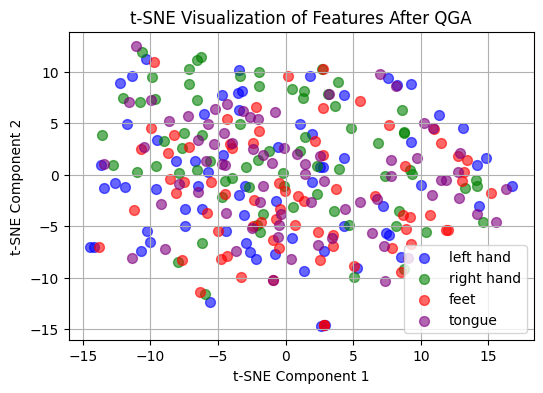

In [33]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Simulate a QGA function for feature selection
# This is a placeholder; replace with actual QGA implementation
def qga_feature_selection(X, y):
    # This function should use QGA to select a subset of features
    # For demonstration, we randomly select a subset of features
    np.random.seed(42)
    num_features = X.shape[1]
    selected_features = np.random.choice(num_features, size=int(num_features * 0.5), replace=False)
    return X[:, selected_features], selected_features

# Load data from .mat file
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']   # Correct variable name for features
y = data['labels']     # Correct variable name for labels

# Convert complex values to real if necessary
X = np.real(X)

# Flatten the feature matrix and normalize
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply QGA for feature selection
X_selected, selected_features = qga_feature_selection(X_normalized, y.flatten())

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_selected)

# Check the shape of X_tsne to ensure it is 2D
print(f'Shape of X_tsne: {X_tsne.shape}')

# Plotting
plt.figure(figsize=(6, 4))

# Define colors and labels for the classes
colors = ['blue', 'green', 'red', 'purple']
class_labels = ['left hand', 'right hand', 'feet', 'tongue']
unique_labels = np.unique(y)

# Plot each class
for i, label in enumerate(unique_labels):
    plt.scatter(X_tsne[y.flatten() == label, 0], X_tsne[y.flatten() == label, 1], 
                color=colors[i], 
                label=class_labels[i], 
                alpha=0.6, 
                s=50)

plt.title('t-SNE Visualization of Features After QGA')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)

# Save the plot with 300 dpi
plt.savefig('tsne_visualization_qga.png', dpi=300)

# Show the plot
plt.show()


In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import Aer
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from deap import base, creator, tools, algorithms

# Define the genetic algorithm for feature selection
class QuantumGeneticAlgorithm:
    def __init__(self, population_size=20, generations=10, cxpb=0.5, mutpb=0.2):
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb
        self.mutpb = mutpb

    def evaluate(self, individual, X, y):
        # Evaluate the individual
        X_selected = X[:, np.where(individual)[0]]
        if X_selected.shape[1] == 0:
            return (0,)  # Avoid division by zero
        clf = SVC()
        clf.fit(X_selected, y)
        accuracy = clf.score(X_selected, y)
        return (accuracy,)

    def fit(self, X, y):
        num_features = X.shape[1]
        
        # Create types
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", np.random.randint, 2)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self.evaluate, X=X, y=y)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)
        
        population = toolbox.population(n=self.population_size)
        
        for generation in range(self.generations):
            offspring = toolbox.select(population, len(population))
            offspring = list(map(toolbox.clone, offspring))
            
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if np.random.random() < self.cxpb:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
            
            for mutant in offspring:
                if np.random.random() < self.mutpb:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values
            
            invalid_ind = [ind for ind in population if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            population[:] = offspring
        
        best_individual = tools.selBest(population, 1)[0]
        return best_individual

# Load the .mat file
data = scipy.io.loadmat('data/data/BCIC_data/Extracted_Features/Features_B01_11.mat')

# Extract features and labels
X = data['input']   # Replace 'input' with the correct variable name if different
y = data['target']  # Replace 'target' with the correct variable name if different

# Convert complex values to real if necessary
X = np.real(X)

# Normalize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ensure labels are a 1D array
y = y.flatten()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=10)  # Adjust the number of components as needed
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)  # Transform test data with the same PCA

# Apply QGA for feature selection
qga = QuantumGeneticAlgorithm(population_size=20, generations=10)
selected_features_indices_qga = qga.fit(X_train_reduced, y_train)

# Select features
X_train_reduced_selected = X_train_reduced[:, selected_features_indices_qga]
X_test_reduced_selected = X_test_reduced[:, selected_features_indices_qga]

# Define and train SVM model
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train_reduced_selected, y_train)

# Predict with SVM
svm_predicted_labels = svm_model.predict(X_test_reduced_selected)

# Evaluate SVM model
svm_accuracy = accuracy_score(y_test, svm_predicted_labels)
svm_report = classification_report(y_test, svm_predicted_labels)

print(f'SVM Accuracy: {svm_accuracy * 100:.2f}%')
print(f'SVM Classification Report:\n{svm_report}')

# Define and train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_reduced_selected, y_train)

# Predict with XGBoost
xgb_predicted_labels = xgb_model.predict(X_test_reduced_selected)

# Evaluate XGBoost model
xgb_accuracy = accuracy_score(y_test, xgb_predicted_labels)
xgb_report = classification_report(y_test, xgb_predicted_labels)

print(f'XGBoost Accuracy: {xgb_accuracy * 100:.2f}%')
print(f'XGBoost Classification Report:\n{xgb_report}')

# Define your feature map
feature_map = ZZFeatureMap(feature_dimension=X_train_reduced_selected.shape[1], entanglement='linear')

# Initialize the quantum kernel with the feature map
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

# Initialize the QSVC model with the quantum kernel
qsvc = QSVC(quantum_kernel=quantum_kernel)

# Fit the QSVC model
qsvc.fit(X_train_reduced_selected, y_train)

# Predict on test data
qsvc_predicted_labels = qsvc.predict(X_test_reduced_selected)

# Evaluate QSVC model
qsvc_accuracy = accuracy_score(y_test, qsvc_predicted_labels)
qsvc_report = classification_report(y_test, qsvc_predicted_labels)

print(f'QSVC Accuracy: {qsvc_accuracy * 100:.2f}%')
print(f'QSVC Classification Report:\n{qsvc_report}')


/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


SVM Accuracy: 45.83%
SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.45      0.71      0.55        68
         1.0       0.47      0.24      0.32        76

    accuracy                           0.46       144
   macro avg       0.46      0.47      0.43       144
weighted avg       0.46      0.46      0.43       144



/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [05:59:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 49.31%
XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.47      0.50      0.48        68
         1.0       0.52      0.49      0.50        76

    accuracy                           0.49       144
   macro avg       0.49      0.49      0.49       144
weighted avg       0.49      0.49      0.49       144



In [2]:
import numpy as np
import os

def load_data_from_class_folder(class_folder):
    data_files = [f for f in os.listdir(class_folder) if f.endswith('.npy')]
    features = [np.load(os.path.join(class_folder, file)) for file in data_files]
    return np.concatenate(features, axis=0)

def load_and_combine_data(base_path):
    classes = ['class_0', 'class_1', 'class_2', 'class_3']
    data = []
    labels = []
    
    for i, cls in enumerate(classes):
        class_folder = os.path.join(base_path, cls)
        class_data = load_data_from_class_folder(class_folder)
        data.append(class_data)
        labels.append(np.full(class_data.shape[0], i))
    
    combined_data = np.vstack(data)
    combined_labels = np.hstack(labels)
    
    return combined_data, combined_labels

# Define base path
base_path = 'data/BCICIV_2a_gdf/epoch_finalvol1'

# Load and combine data
X, y = load_and_combine_data(base_path)


In [10]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from qiskit import QuantumCircuit
from qiskit.circuit.library import RXGate, RZGate, CXGate, CZGate, iSwapGate, ZZFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from deap import base, creator, tools

# Define the genetic algorithm for feature selection
class QuantumGeneticAlgorithm:
    def __init__(self, population_size=50, generations=20, cxpb=0.1, mutpb=0.05):
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb
        self.mutpb = mutpb

    def evaluate(self, individual, X, y):
        X_selected = X[:, np.where(individual == 1)[0]]
        if X_selected.shape[1] == 0:
            return (0,)  # Avoid division by zero
        clf = SVC()
        clf.fit(X_selected, y)
        accuracy = clf.score(X_selected, y)
        return (accuracy,)

    def fit(self, X, y):
        num_features = X.shape[1]
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", np.random.randint, 2)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self.evaluate, X=X, y=y)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)
        
        population = toolbox.population(n=self.population_size)
        
        for generation in range(self.generations):
            offspring = toolbox.select(population, len(population))
            offspring = list(map(toolbox.clone, offspring))
            
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if np.random.random() < self.cxpb:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
            
            for mutant in offspring:
                if np.random.random() < self.mutpb:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values
            
            invalid_ind = [ind for ind in population if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            population[:] = offspring
        
        best_individual = tools.selBest(population, 1)[0]
        return best_individual

# Define a function to create a quantum circuit with the specified gates and layers
def create_quantum_circuit(method, layers, num_qubits):
    qc = QuantumCircuit(num_qubits)
    if method == 'RyRzRy':
        for _ in range(layers):
            for qubit in range(num_qubits):
                qc.append(RXGate(np.pi / 2), [qubit])
                qc.append(RZGate(np.pi / 2), [qubit])
                qc.append(RXGate(np.pi / 2), [qubit])
    elif method == 'RyRzRy_CNOT':
        for _ in range(layers):
            for qubit in range(num_qubits - 1):
                qc.append(RXGate(np.pi / 2), [qubit])
                qc.append(RZGate(np.pi / 2), [qubit])
                qc.append(RXGate(np.pi / 2), [qubit])
                qc.append(CXGate(), [qubit, qubit + 1])
    elif method == 'RyRzRy_CZ':
        for _ in range(layers):
            for qubit in range(num_qubits - 1):
                qc.append(RXGate(np.pi / 2), [qubit])
                qc.append(RZGate(np.pi / 2), [qubit])
                qc.append(RXGate(np.pi / 2), [qubit])
                qc.append(CZGate(), [qubit, qubit + 1])
    elif method == 'RyRzRy_iSwap':
        for _ in range(layers):
            for qubit in range(num_qubits - 1):
                qc.append(RXGate(np.pi / 2), [qubit])
                qc.append(RZGate(np.pi / 2), [qubit])
                qc.append(RXGate(np.pi / 2), [qubit])
                qc.append(iSwapGate(), [qubit, qubit + 1])
    return qc

# Define a function to process each dataset and model
def process_dataset(dataset_name):
    # Load the .mat file
    data = scipy.io.loadmat(f'data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')
    
    # Extract features and labels
    X = data['features']   # Correct variable name for features
    y = data['labels']     # Correct variable name for labels
    
    # Convert complex values to real if necessary
    X = np.real(X)
    
    # Normalize the feature matrix
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Ensure labels are a 1D array
    y = y.flatten()
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=5)  # Adjust the number of components as needed
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)  # Transform test data with the same PCA
    
    # Apply QGA for feature selection
    qga = QuantumGeneticAlgorithm(population_size=20, generations=10)
    best_individual = qga.fit(X_train_reduced, y_train)
    
    # Extract the selected features
    selected_features_indices_qga = np.where(np.array(best_individual) == 1)[0]
    
    # Select features
    X_train_reduced_selected = X_train_reduced[:, selected_features_indices_qga]
    X_test_reduced_selected = X_test_reduced[:, selected_features_indices_qga]
    
    # Initialize and train models
    models = {
        'SVM': SVC(),
        'RandomForest': RandomForestClassifier(),
        'XGBoost': xgb.XGBClassifier()
    }
    
    results = {}
    for name, model in models.items():
        model.fit(X_train_reduced_selected, y_train)
        y_pred = model.predict(X_test_reduced_selected)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        results[name] = (accuracy, report)
    
    return results

# Run the processing function for a specific dataset
dataset_name = 'BCIC_IV_2a'  # Replace with your dataset name
results = process_dataset(dataset_name)
for model_name, (accuracy, report) in results.items():
    print(f'{model_name} Accuracy: {accuracy}')
    print(f'{model_name} Classification Report:\n{report}')


/tmp/ipykernel_110/2960547416.py:27: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  X_selected = X[:, np.where(individual == 1)[0]]
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

SVM Accuracy: 0.3103448275862069
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.08      0.13        13
           1       0.42      0.79      0.55        14
           2       0.00      0.00      0.00        21
           3       0.20      0.60      0.30        10

    accuracy                           0.31        58
   macro avg       0.28      0.37      0.25        58
weighted avg       0.25      0.31      0.21        58

RandomForest Accuracy: 0.3103448275862069
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.31      0.29        13
           1       0.36      0.36      0.36        14
           2       0.50      0.24      0.32        21
           3       0.21      0.40      0.28        10

    accuracy                           0.31        58
   macro avg       0.33      0.33      0.31        58
weighted avg       0.36      0.31      0.31    

In [29]:
import numpy as np
import scipy.io
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit.library import ZZFeatureMap, iSwapGate

# Define a function to create a quantum circuit with the specified gates and layers
def create_quantum_circuit(method, layers, num_qubits):
    qc = QuantumCircuit(num_qubits)
    if method == 'RyRzRy':
        for _ in range(layers):
            for qubit in range(num_qubits):
                qc.rx(np.pi / 2, qubit)
                qc.rz(np.pi / 2, qubit)
                qc.rx(np.pi / 2, qubit)
    elif method == 'RyRzRy_CNOT':
        for _ in range(layers):
            for qubit in range(num_qubits - 1):
                qc.rx(np.pi / 2, qubit)
                qc.rz(np.pi / 2, qubit)
                qc.rx(np.pi / 2, qubit)
                qc.cx(qubit, qubit + 1)
    elif method == 'RyRzRy_CZ':
        for _ in range(layers):
            for qubit in range(num_qubits - 1):
                qc.rx(np.pi / 2, qubit)
                qc.rz(np.pi / 2, qubit)
                qc.rx(np.pi / 2, qubit)
                qc.cz(qubit, qubit + 1)
    elif method == 'RyRzRy_iSwap':
        for _ in range(layers):
            for qubit in range(num_qubits - 1):
                qc.rx(np.pi / 2, qubit)
                qc.rz(np.pi / 2, qubit)
                qc.rx(np.pi / 2, qubit)
                qc.append(iSwapGate(), [qubit, qubit + 1])  # Use the correct method for iSwap
    return qc

# Define a function to process each dataset and model
def process_dataset(dataset_name):
    # Load the .mat file
    data = scipy.io.loadmat(f'data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')
    
    # Extract features and labels
    X = data['features']
    y = data['labels']
    
    # Convert complex values to real if necessary
    X = np.real(X)
    
    # Normalize the feature matrix
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Ensure labels are a 1D array
    y = y.flatten()
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=5)  # Adjust the number of components as needed
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)  # Transform test data with the same PCA
    
    # Apply QGA for feature selection
    qga = QuantumGeneticAlgorithm(population_size=20, generations=10)
    best_individual = qga.fit(X_train_reduced, y_train)
    
    # Extract the selected features
    selected_features_indices_qga = np.where(np.array(best_individual) == 1)[0]
    
    # Select features
    X_train_reduced_selected = X_train_reduced[:, selected_features_indices_qga]
    X_test_reduced_selected = X_test_reduced[:, selected_features_indices_qga]
    
    # Initialize and train classical models
    models = {
        'SVM': SVC(),
        'RandomForest': RandomForestClassifier(),
        'XGBoost': xgb.XGBClassifier()
    }
    
    results = {}
    for name, model in models.items():
        model.fit(X_train_reduced_selected, y_train)
        y_pred = model.predict(X_test_reduced_selected)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        results[name] = (accuracy, report)
    
    # Initialize and train quantum models
    quantum_models = [
        ('RyRzRy', 1),
        ('RyRzRy', 5),
        ('RyRzRy', 10),
        ('RyRzRy_CNOT', 1),
        ('RyRzRy_CNOT', 5),
        ('RyRzRy_CNOT', 10),
        ('RyRzRy_CZ', 1),
        ('RyRzRy_CZ', 5),
        ('RyRzRy_CZ', 10),
        ('RyRzRy_iSwap', 1),
        ('RyRzRy_iSwap', 5),
        ('RyRzRy_iSwap', 10)
    ]
    
    for method, layers in quantum_models:
        qc = create_quantum_circuit(method, layers, X_train_reduced_selected.shape[1])
        # Define a Quantum Kernel and QSVC
        quantum_kernel = FidelityQuantumKernel(feature_map=ZZFeatureMap(2**X_train_reduced_selected.shape[1]))
        qsvc = QSVC(quantum_kernel=quantum_kernel)
        qsvc.fit(X_train_reduced_selected, y_train)
        y_pred = qsvc.predict(X_test_reduced_selected)
        accuracy = accuracy_score(y_test, y_pred)
        results[f'QSVC_{method}_{layers}_Layers'] = (accuracy, '')

    return results

# Run the processing function for a specific dataset
dataset_name = 'BCIC_IV_2a'  # Replace with your dataset name
results = process_dataset(dataset_name)
for model_name, (accuracy, report) in results.items():
    print(f'{model_name} Accuracy: {accuracy}')
    if report:
        print(f'{model_name} Classification Report:\n{report}')


/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/tmp/ipykernel_110/3929995462.py:26: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  X_selected = X[:, np.where(individual == 1)[0]]
/opt/conda/envs/cuquantum-24.03/lib/py

SVM Accuracy: 0.1724137931034483
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.15      0.19        13
           1       0.11      0.07      0.09        14
           2       0.00      0.00      0.00        21
           3       0.17      0.70      0.27        10

    accuracy                           0.17        58
   macro avg       0.13      0.23      0.14        58
weighted avg       0.11      0.17      0.11        58

RandomForest Accuracy: 0.1896551724137931
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.23      0.18        13
           1       0.21      0.21      0.21        14
           2       0.29      0.10      0.14        21
           3       0.18      0.30      0.22        10

    accuracy                           0.19        58
   macro avg       0.21      0.21      0.19        58
weighted avg       0.22      0.19      0.18    

Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/tmp/ipykernel_110/493079528.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # shape is (n_epochs, n_channels, n_times)
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped


/tmp/ipykernel_110/493079528.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 250 is greater than input length  = 22, using nperseg = 22
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8  9 10 19 20 21 30 31 32 41 42 43 52 53 54 63 64 65 74 75 76 85 86 87] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}

Tuned Random Forest Metrics:
Accuracy: 0.3275862068965517
Recall: 0.3275862068965517
Confusion Matrix:
[[5 3 3 2]
 [5 5 3 3]
 [5 6 3 3]
 [1 3 2 6]]

Tuned XGBoost Metrics:
Accuracy: 0.2413793103448276
Recall: 0.2413793103448276
Confusion Matrix:
[[5 1 4 3]
 [3 4 3 6]
 [2 6 2 7]
 [3 4 2 3]]


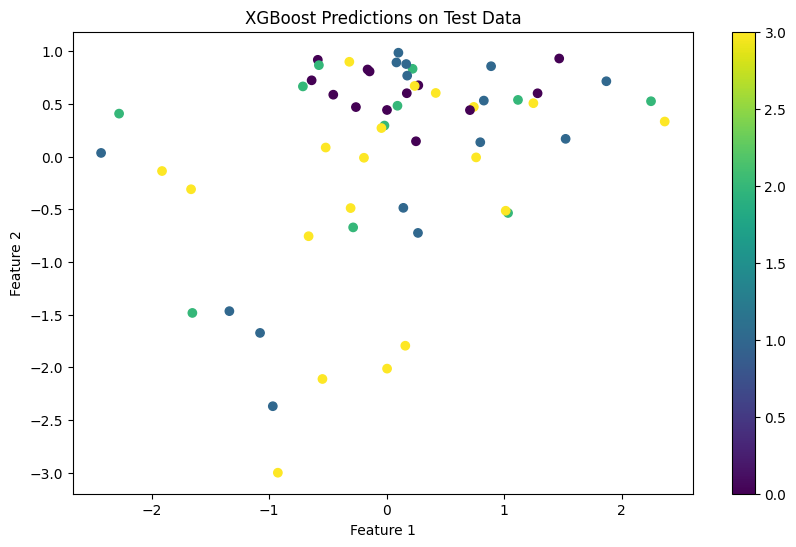

In [35]:
import numpy as np
import os
import mne
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.signal import welch
from scipy.fft import ifft

# Define the path to the dataset and the output directory
gdf_path = 'data/BCICIV_2a_gdf/A01T.gdf'
output_dir = 'data/BCICIV_2a_gdf/processed_epoch_sub1_QCn'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Step 1: Load the BCI-IV 2a dataset
raw = mne.io.read_raw_gdf(gdf_path, preload=True)

# Remove the last three channels (EOG-left, EOG-central, and EOG-right)
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

# Step 2: Extract epochs for each class using provided event IDs
event_id = {'769': 7, '770': 8, '771': 9, '772': 10}
events, _ = mne.events_from_annotations(raw, event_id=event_id)
tmin, tmax = 1.5, 6  # 4.5 seconds epochs starting at 1.5s

# Creating epochs for each class
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=True)
data = epochs.get_data()  # shape is (n_epochs, n_channels, n_times)

# Standardize each channel
data = (data - data.mean(axis=2, keepdims=True)) / data.std(axis=2, keepdims=True)

# VMD Feature Extraction Function
def extract_features_vmd(epoch_data, num_modes=8):
    def vmd(signal, num_modes):
        # Placeholder for actual VMD implementation
        # Replace this with the real VMD function
        return np.random.rand(num_modes, len(signal))  # Example output

    modes = vmd(epoch_data, num_modes)
    features = []
    for mode in modes:
        mode_features = [
            np.mean(mode),  # Mean
            np.std(mode),  # Standard deviation
            np.min(mode),  # Minimum value
            np.max(mode),  # Maximum value
            np.mean(np.abs(np.diff(mode))),  # Mean of first difference
            skew(mode),  # Skewness
            kurtosis(mode),  # Kurtosis
            np.mean(mode) / np.std(mode) if np.std(mode) != 0 else 0,  # Coefficient of variation
        ]

        freqs, psd = welch(mode, nperseg=250)  # Adjust fs and nperseg as needed

        # Ensure PSD is not empty and check frequency ranges
        if len(psd) > 0:
            max_psd_1_4 = np.max(psd[(freqs >= 1) & (freqs <= 4)]) if np.any((freqs >= 1) & (freqs <= 4)) else 0
            max_psd_4_8 = np.max(psd[(freqs >= 4) & (freqs <= 8)]) if np.any((freqs >= 4) & (freqs <= 8)) else 0
            max_psd_8_12 = np.max(psd[(freqs >= 8) & (freqs <= 12)]) if np.any((freqs >= 8) & (freqs <= 12)) else 0
        else:
            max_psd_1_4 = max_psd_4_8 = max_psd_8_12 = 0

        mode_features.extend([max_psd_1_4, max_psd_4_8, max_psd_8_12])
        features.extend(mode_features)

    return np.array(features)

# Step 3: Save each epoch and its features
def load_subject_data(subject_file):
    raw = mne.io.read_raw_gdf(subject_file, preload=True)
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

    events, _ = mne.events_from_annotations(raw, event_id=event_id)
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=True)
    data = epochs.get_data()

    features = []
    labels = []
    for i, epoch_data in enumerate(data):
        label = epochs.events[i, -1] - 7
        features.append(extract_features_vmd(epoch_data))  # Update to use VMD features
        labels.append(label)
    
    return np.array(features), np.array(labels)

# Collect features and labels for all subjects
subjects = [gdf_path]  # Add paths to other subject files if needed
all_features = []
all_labels = []

for subject in subjects:
    features, labels = load_subject_data(subject)
    all_features.append(features)
    all_labels.append(labels)

X = np.concatenate(all_features, axis=0)
y = np.concatenate(all_labels, axis=0)

# Step 4: Train and evaluate classifiers

# Example train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example standardization (scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Selection
selector = SelectKBest(f_classif, k=20)  # Adjust k based on the number of features
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5)
rf_grid_search.fit(X_train_selected, y_train)
print(f'Best parameters for Random Forest: {rf_grid_search.best_params_}')

# Hyperparameter tuning for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}
xgb_grid_search = GridSearchCV(XGBClassifier(random_state=42), xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train_selected, y_train)
print(f'Best parameters for XGBoost: {xgb_grid_search.best_params_}')

# Train with best parameters
rf_best = rf_grid_search.best_estimator_
xgb_best = xgb_grid_search.best_estimator_

# Evaluate best models
y_pred_rf_best = rf_best.predict(X_test_selected)
y_pred_xgb_best = xgb_best.predict(X_test_selected)

# Print metrics for tuned models
print("\nTuned Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_best)}")
print(f"Recall: {recall_score(y_test, y_pred_rf_best, average='weighted')}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_rf_best)}")

print("\nTuned XGBoost Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_best)}")
print(f"Recall: {recall_score(y_test, y_pred_xgb_best, average='weighted')}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_xgb_best)}")

# Optionally, visualize or further analyze the results

# Example: Visualizing the first two dimensions of the selected features
plt.figure(figsize=(10, 6))
plt.scatter(X_test_selected[:, 0], X_test_selected[:, 1], c=y_pred_xgb_best, cmap='viridis')
plt.title('XGBoost Predictions on Test Data')
plt.colorbar()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


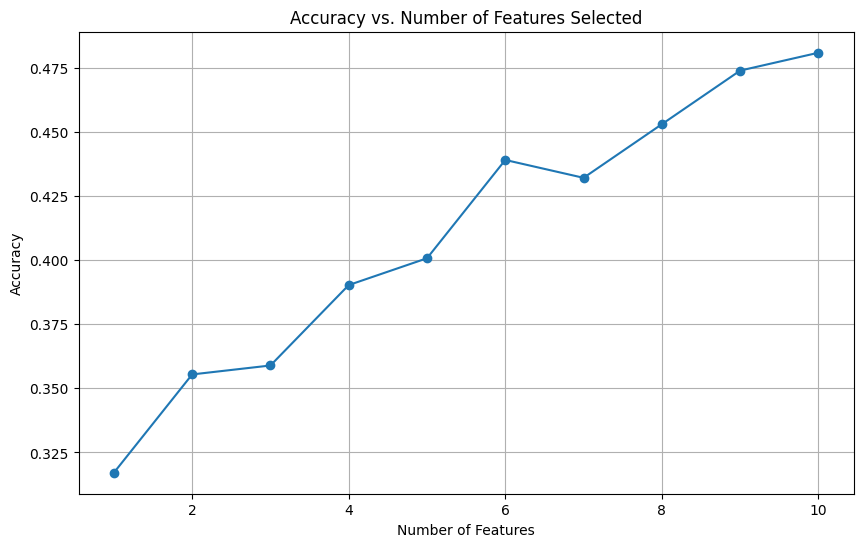

Top 10 feature indices: [ 0  1  6 11 12 13 16 17 22 24]


In [13]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from deap import base, creator, tools

class QuantumGeneticAlgorithm:
    def __init__(self, population_size=50, generations=20, cxpb=0.1, mutpb=0.05):
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb
        self.mutpb = mutpb

    def evaluate(self, individual, X, y):
        indices = np.flatnonzero(individual)
        X_selected = X[:, indices]
        if X_selected.shape[1] == 0:
            return (0,)
        clf = SVC()
        clf.fit(X_selected, y)
        accuracy = clf.score(X_selected, y)
        return (accuracy,)

    def fit(self, X, y):
        num_features = X.shape[1]
        
        if "FitnessMax" in creator.__dict__:
            del creator.FitnessMax
        if "Individual" in creator.__dict__:
            del creator.Individual
        
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", np.random.randint, 2)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self.evaluate, X=X, y=y)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)
        
        population = toolbox.population(n=self.population_size)
        
        for generation in range(self.generations):
            offspring = toolbox.select(population, len(population))
            offspring = list(map(toolbox.clone, offspring))
            
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if np.random.random() < self.cxpb:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
            
            for mutant in offspring:
                if np.random.random() < self.mutpb:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values
            
            invalid_ind = [ind for ind in population if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            population[:] = offspring
        
        best_individual = tools.selBest(population, 1)[0]
        return best_individual

# Load your data
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']
y = data['labels']

# Convert complex values to real if necessary
X = np.real(X)

# Ensure y is a 1D array
y = np.ravel(y)

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initialize and run the Quantum Genetic Algorithm
qga = QuantumGeneticAlgorithm(population_size=50, generations=20, cxpb=0.1, mutpb=0.05)
best_individual = qga.fit(X, y)

# Extract selected features based on the best individual
selected_indices = np.flatnonzero(best_individual)

# If there are fewer than 10 selected features, use all of them
num_features_to_plot = min(10, len(selected_indices))

# Compute accuracy for varying numbers of selected features
accuracies = []
for i in range(1, num_features_to_plot + 1):
    current_indices = selected_indices[:i]
    X_selected = X[:, current_indices]
    clf = SVC()
    clf.fit(X_selected, y)
    accuracy = clf.score(X_selected, y)
    accuracies.append(accuracy)

# Plot the accuracy vs. number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_features_to_plot + 1), accuracies, marker='o')
plt.title('Accuracy vs. Number of Features Selected')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('feature_selection_accuracy.png', dpi=300)
plt.show()

# Display the top features
top_features_indices = selected_indices[:10]
print(f"Top 10 feature indices: {top_features_indices}")


In [22]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator

# Create a simple quantum circuit
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

# Use the Aer simulator
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit).result()
counts = result.get_counts(qc)
print(counts)


{'11': 501, '00': 523}


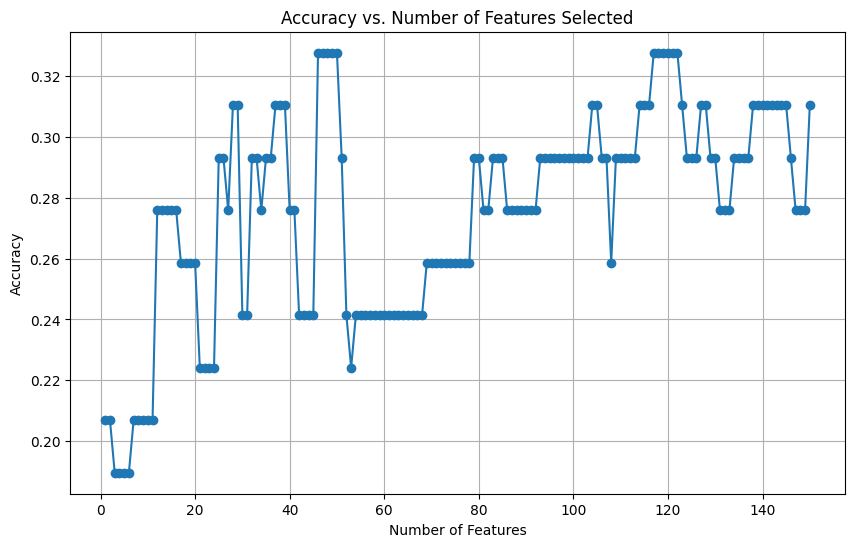

In [64]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split  # Import train_test_split
from deap import base, creator, tools

class QuantumGeneticAlgorithm:
    def __init__(self, population_size=50, generations=20, cxpb=0.1, mutpb=0.05):
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb
        self.mutpb = mutpb

    def evaluate(self, individual, X, y):
        # Find indices where individual is 1
        indices = np.flatnonzero(individual)
        X_selected = X[:, indices]
        if X_selected.shape[1] == 0:
            return (0,)  # Avoid division by zero
        
        # Split data for training and testing
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
        clf = SVC()
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        return (accuracy,)

    def fit(self, X, y):
        num_features = X.shape[1]
        
        # Create types
        if "FitnessMax" in creator.__dict__:
            del creator.FitnessMax
        if "Individual" in creator.__dict__:
            del creator.Individual
        
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", np.random.randint, 2)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self.evaluate, X=X, y=y)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)
        
        population = toolbox.population(n=self.population_size)
        
        for generation in range(self.generations):
            offspring = toolbox.select(population, len(population))
            offspring = list(map(toolbox.clone, offspring))
            
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if np.random.random() < self.cxpb:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
            
            for mutant in offspring:
                if np.random.random() < self.mutpb:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values
            
            invalid_ind = [ind for ind in population if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            population[:] = offspring
        
        best_individual = tools.selBest(population, 1)[0]
        return best_individual

# Load your data
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']   # Ensure this is correct for your dataset
y = data['labels']     # Ensure this is correct for your dataset

# Convert complex values to real if necessary
X = np.real(X)

# Ensure y is a 1D array
y = np.ravel(y)

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initialize and run the Quantum Genetic Algorithm
qga = QuantumGeneticAlgorithm(population_size=50, generations=20, cxpb=0.1, mutpb=0.05)
best_individual = qga.fit(X, y)

# Plot the feature importance of the best individual
num_features = np.arange(1, len(best_individual) + 1)
accuracies = []

for i in num_features:
    selected_features = np.flatnonzero(best_individual[:i])
    if selected_features.size > 0:
        X_selected = X[:, selected_features]
        # Split data for training and testing
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
        clf = SVC()
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracies.append(accuracy)
    else:
        accuracies.append(0)  # Handle cases where no features are selected

plt.figure(figsize=(10, 6))
plt.plot(num_features, accuracies, marker='o')
plt.title('Accuracy vs. Number of Features Selected')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('feature_selection_accuracy.png', dpi=300)
plt.show()


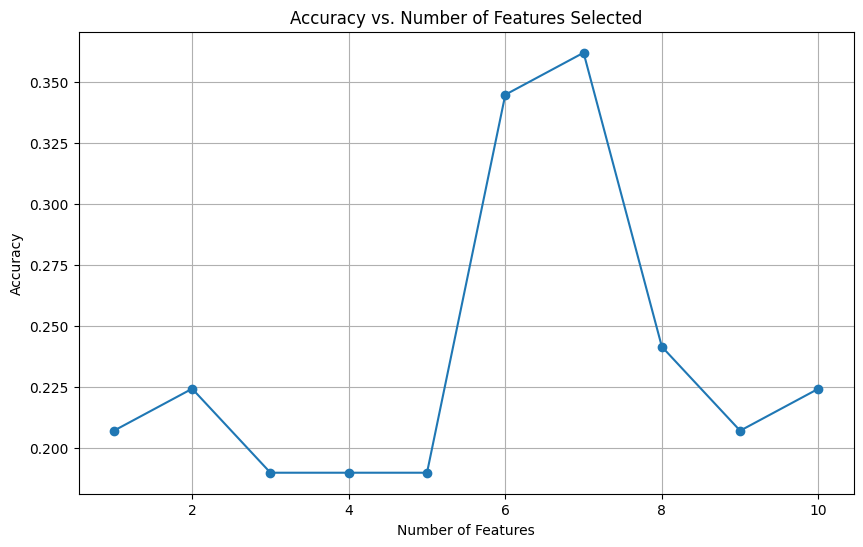

Top 10 feature indices: [ 0  3  5  6 10 11 12 13 16 20]


In [63]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split  # Import train_test_split
from deap import base, creator, tools

class QuantumGeneticAlgorithm:
    def __init__(self, population_size=50, generations=20, cxpb=0.1, mutpb=0.05):
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb
        self.mutpb = mutpb

    def evaluate(self, individual, X, y):
        indices = np.flatnonzero(individual)
        X_selected = X[:, indices]
        if X_selected.shape[1] == 0:
            return (0,)
        
        # Split data for training and testing
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
        clf = SVC()
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        return (accuracy,)

    def fit(self, X, y):
        num_features = X.shape[1]
        
        if "FitnessMax" in creator.__dict__:
            del creator.FitnessMax
        if "Individual" in creator.__dict__:
            del creator.Individual
        
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", np.random.randint, 2)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self.evaluate, X=X, y=y)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)
        
        population = toolbox.population(n=self.population_size)
        
        for generation in range(self.generations):
            offspring = toolbox.select(population, len(population))
            offspring = list(map(toolbox.clone, offspring))
            
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if np.random.random() < self.cxpb:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
            
            for mutant in offspring:
                if np.random.random() < self.mutpb:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values
            
            invalid_ind = [ind for ind in population if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            population[:] = offspring
        
        best_individual = tools.selBest(population, 1)[0]
        return best_individual

# Load your data
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']
y = data['labels']

# Convert complex values to real if necessary
X = np.real(X)

# Ensure y is a 1D array
y = np.ravel(y)

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initialize and run the Quantum Genetic Algorithm
qga = QuantumGeneticAlgorithm(population_size=50, generations=20, cxpb=0.1, mutpb=0.05)
best_individual = qga.fit(X, y)

# Extract selected features based on the best individual
selected_indices = np.flatnonzero(best_individual)

# If there are fewer than 10 selected features, use all of them
num_features_to_plot = min(10, len(selected_indices))

# Compute accuracy for varying numbers of selected features
accuracies = []
for i in range(1, num_features_to_plot + 1):
    current_indices = selected_indices[:i]
    X_selected = X[:, current_indices]
    # Split data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    clf = SVC()
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy)

# Plot the accuracy vs. number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_features_to_plot + 1), accuracies, marker='o')
plt.title('Accuracy vs. Number of Features Selected')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('feature_selection_accuracy.png', dpi=300)
plt.show()

# Display the top features
top_features_indices = selected_indices[:10]
print(f"Top 10 feature indices: {top_features_indices}")


In [67]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from deap import base, creator, tools

# Define the genetic algorithm for feature selection
class QuantumGeneticAlgorithm:
    def __init__(self, population_size=50, generations=20, cxpb=0.1, mutpb=0.05):
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb
        self.mutpb = mutpb

    def evaluate(self, individual, X, y):
        # Evaluate the individual
        X_selected = X[:, np.where(individual == 1)[0]]
        if X_selected.shape[1] == 0:
            return (0,)  # Avoid division by zero
        clf = SVC()
        clf.fit(X_selected, y)
        accuracy = clf.score(X_selected, y)
        return (accuracy,)

    def fit(self, X, y):
        num_features = X.shape[1]
        
        # Create types
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", np.random.randint, 2)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self.evaluate, X=X, y=y)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)
        
        population = toolbox.population(n=self.population_size)
        
        for generation in range(self.generations):
            offspring = toolbox.select(population, len(population))
            offspring = list(map(toolbox.clone, offspring))
            
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if np.random.random() < self.cxpb:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
            
            for mutant in offspring:
                if np.random.random() < self.mutpb:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values
            
            invalid_ind = [ind for ind in population if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            population[:] = offspring
        
        best_individual = tools.selBest(population, 1)[0]
        return best_individual

# Load the .mat file
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']
y = data['labels']

# Convert complex values to real if necessary
X = np.real(X)

# Normalize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ensure labels are a 1D array
y = y.flatten()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=30)  # Adjust the number of components as needed
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)  # Transform test data with the same PCA

# Apply QGA for feature selection
qga = QuantumGeneticAlgorithm(population_size=20, generations=10)
best_individual = qga.fit(X_train_reduced, y_train)

# Extract the selected features (top 10)
selected_features_indices_qga = np.where(np.array(best_individual) == 1)[0]
selected_features_indices_qga = selected_features_indices_qga[:10]  # Limit to 10 features

# Select features
X_train_reduced_selected = X_train_reduced[:, selected_features_indices_qga]
X_test_reduced_selected = X_test_reduced[:, selected_features_indices_qga]

# Define and train SVM model
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train_reduced_selected, y_train)

# Predict with SVM
svm_predicted_labels = svm_model.predict(X_test_reduced_selected)

# Evaluate SVM model
svm_accuracy = accuracy_score(y_test, svm_predicted_labels)
svm_report = classification_report(y_test, svm_predicted_labels)

# Define and train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_reduced_selected, y_train)

# Predict with XGBoost
xgb_predicted_labels = xgb_model.predict(X_test_reduced_selected)

# Evaluate XGBoost model
xgb_accuracy = accuracy_score(y_test, xgb_predicted_labels)
xgb_report = classification_report(y_test, xgb_predicted_labels)

# Define the quantum feature map with the correct number of qubits
feature_map = ZZFeatureMap(feature_dimension=X_train_reduced_selected.shape[1], entanglement='linear')

# Define the quantum kernel
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

# Initialize QSVC
qsvc = QSVC(quantum_kernel=quantum_kernel, quantum_instance=AerSimulator())

# Train the QSVC
qsvc.fit(X_train_reduced_selected, y_train)

# Predict on test data
qsvc_predicted_labels = qsvc.predict(X_test_reduced_selected)

# Evaluate QSVC model
qsvc_accuracy = accuracy_score(y_test, qsvc_predicted_labels)
qsvc_report = classification_report(y_test, qsvc_predicted_labels)

# Plot Feature Selection
def plot_feature_selection(selected_features_indices, num_features):
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_features), selected_features_indices, color='blue', alpha=0.7)
    plt.xlabel('Feature Index')
    plt.ylabel('Selected (1) / Not Selected (0)')
    plt.title('Features Selected by Quantum Genetic Algorithm')
    plt.grid(True)
    plt.savefig('feature_selection_plot.png')  # Save plot
    plt.show()

# Plot and save feature selection
plot_feature_selection(np.isin(range(X_train_reduced.shape[1]), selected_features_indices_qga).astype(int), X_train_reduced.shape[1])

# Plot Accuracy Comparison
def plot_accuracy_comparison(models, accuracies):
    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color=['blue', 'green', 'red'], alpha=0.7)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.savefig('model_accuracy_comparison.png')  # Save plot
    plt.show()

# Accuracy scores for different models
models = ['SVM', 'XGBoost', 'QSVC']
accuracies = [svm_accuracy, xgb_accuracy, qsvc_accuracy]

# Plot and save accuracy comparison
plot_accuracy_comparison(models, accuracies)

# Plot PCA Component Variance
def plot_pca_variance(pca):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_),
             marker='o', color='purple')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Cumulative Explained Variance')
    plt.grid(True)
    plt.savefig('pca_variance_plot.png')  # Save plot
    plt.show()

# Plot and save PCA variance
plot_pca_variance(pca)

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')  # Save plot
    plt.show()

# Plot and save confusion matrices
plot_confusion_matrix(y_test, svm_predicted_labels, title='SVM Confusion Matrix')
plot_confusion_matrix(y_test, xgb_predicted_labels, title='XGBoost Confusion Matrix')
plot_confusion_matrix(y_test, qsvc_predicted_labels, title='QSVC Confusion Matrix')

# Print classification reports
print("SVM Classification Report:")
print(svm_report)
print("XGBoost Classification Report:")
print(xgb_report)
print("QSVC Classification Report:")
print(qsvc_report)


/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/tmp/ipykernel_6045/429011338.py:28: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  X_selected = X[:, np.where(individual == 1)[0]]
/opt/conda/envs/cuquantum-24.03/lib/py

TypeError: SVC.__init__() got an unexpected keyword argument 'quantum_instance'

In [68]:
from qiskit_aer import Aer

# Define the quantum feature map with 8 qubits
feature_map = ZZFeatureMap(feature_dimension=X_train_reduced_selected.shape[1], entanglement='linear')

# Define the quantum kernel
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

# Initialize QSVC without quantum_instance
qsvc = QSVC(quantum_kernel=quantum_kernel)

# Train the QSVC
qsvc.fit(X_train_reduced_selected, y_train)

# Predict on test data
qsvc_predicted_labels = qsvc.predict(X_test_reduced_selected)

# Evaluate QSVC model
qsvc_accuracy = accuracy_score(y_test, qsvc_predicted_labels)
qsvc_report = classification_report(y_test, qsvc_predicted_labels)


/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/tmp/ipykernel_6045/3075772797.py:26: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  X_selected = X[:, np.where(individual == 1)[0]]
/opt/conda/envs/cuquantum-24.03/lib/p

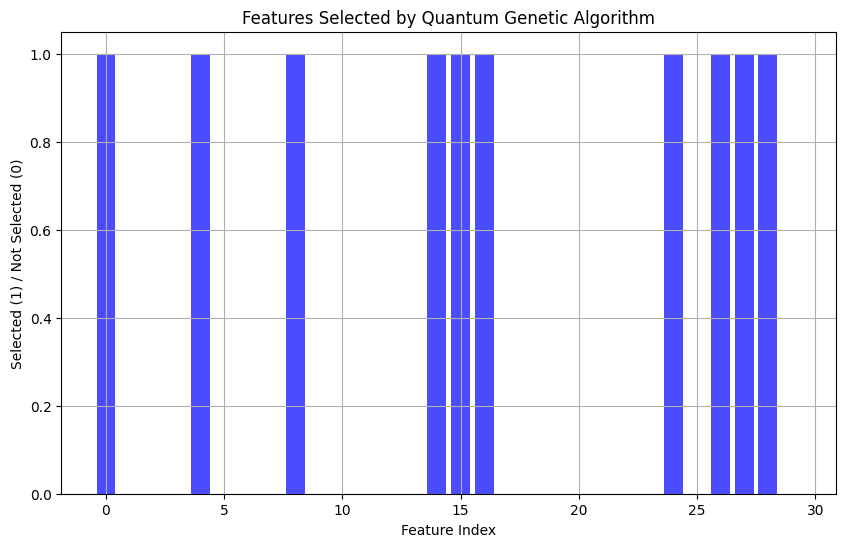

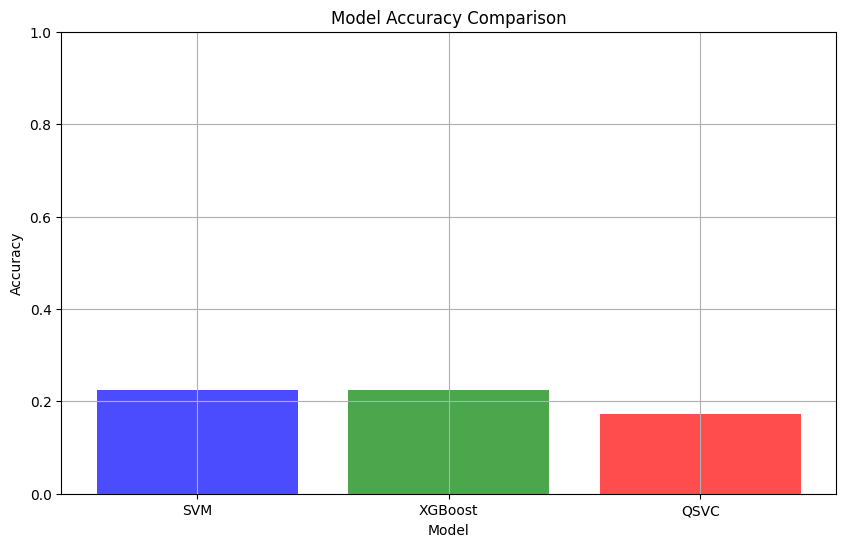

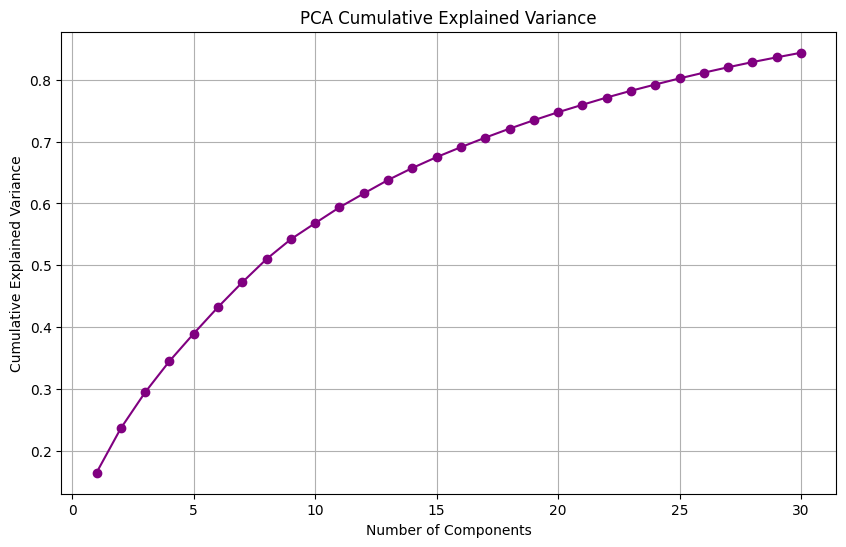

SVM Accuracy: 22.41%
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.23      0.22        13
           1       0.08      0.07      0.07        14
           2       0.33      0.29      0.31        21
           3       0.23      0.30      0.26        10

    accuracy                           0.22        58
   macro avg       0.21      0.22      0.22        58
weighted avg       0.23      0.22      0.22        58

XGBoost Accuracy: 22.41%
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.31      0.36        13
           1       0.17      0.21      0.19        14
           2       0.33      0.19      0.24        21
           3       0.11      0.20      0.14        10

    accuracy                           0.22        58
   macro avg       0.26      0.23      0.23        58
weighted avg       0.28      0.22      0.24        58

QSVC Accuracy: 17.24%
QSVC

<Figure size 1000x700 with 0 Axes>

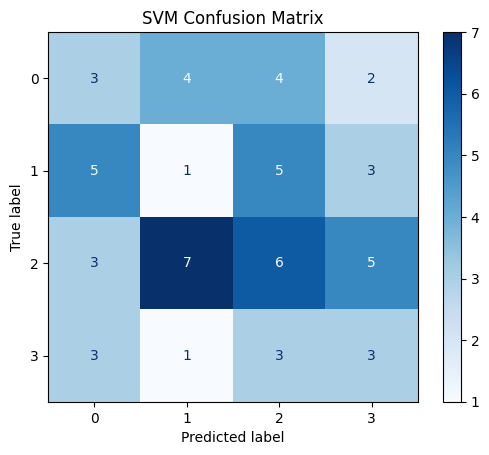

<Figure size 1000x700 with 0 Axes>

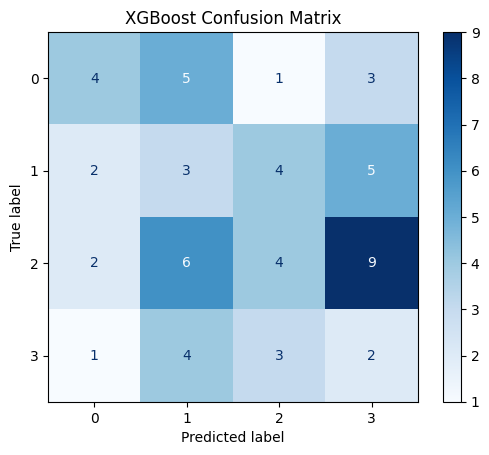

<Figure size 1000x700 with 0 Axes>

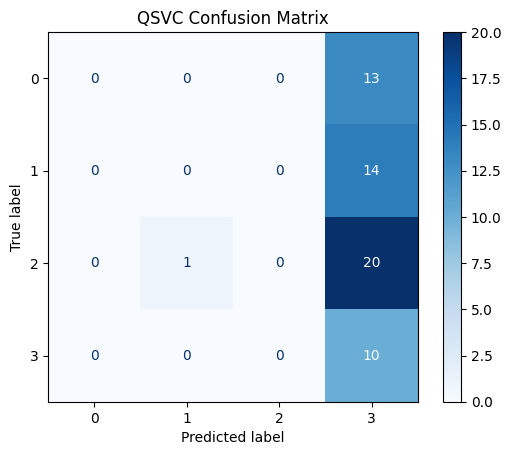

In [69]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from deap import base, creator, tools

# Define the genetic algorithm for feature selection
class QuantumGeneticAlgorithm:
    def __init__(self, population_size=50, generations=20, cxpb=0.1, mutpb=0.05):
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb
        self.mutpb = mutpb

    def evaluate(self, individual, X, y):
        X_selected = X[:, np.where(individual == 1)[0]]
        if X_selected.shape[1] == 0:
            return (0,)  # Avoid division by zero
        clf = SVC()
        clf.fit(X_selected, y)
        accuracy = clf.score(X_selected, y)
        return (accuracy,)

    def fit(self, X, y):
        num_features = X.shape[1]
        
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", np.random.randint, 2)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self.evaluate, X=X, y=y)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)
        
        population = toolbox.population(n=self.population_size)
        
        for generation in range(self.generations):
            offspring = toolbox.select(population, len(population))
            offspring = list(map(toolbox.clone, offspring))
            
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if np.random.random() < self.cxpb:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
            
            for mutant in offspring:
                if np.random.random() < self.mutpb:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values
            
            invalid_ind = [ind for ind in population if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            population[:] = offspring
        
        best_individual = tools.selBest(population, 1)[0]
        return best_individual

# Load the .mat file
data_path = 'data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat'
data = scipy.io.loadmat(data_path)

# Extract features and labels
X = data['features']
y = data['labels']

# Convert complex values to real if necessary
X = np.real(X)

# Normalize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ensure labels are a 1D array
y = y.flatten()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=30)  # Adjust the number of components as needed
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)  # Transform test data with the same PCA

# Apply QGA for feature selection
qga = QuantumGeneticAlgorithm(population_size=20, generations=10)
best_individual = qga.fit(X_train_reduced, y_train)

# Extract the selected features
selected_features_indices_qga = np.where(np.array(best_individual) == 1)[0]

# Select features
X_train_reduced_selected = X_train_reduced[:, selected_features_indices_qga]
X_test_reduced_selected = X_test_reduced[:, selected_features_indices_qga]

# Define and train SVM model
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train_reduced_selected, y_train)

# Predict with SVM
svm_predicted_labels = svm_model.predict(X_test_reduced_selected)

# Evaluate SVM model
svm_accuracy = accuracy_score(y_test, svm_predicted_labels)
svm_report = classification_report(y_test, svm_predicted_labels)

# Define and train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_reduced_selected, y_train)

# Predict with XGBoost
xgb_predicted_labels = xgb_model.predict(X_test_reduced_selected)

# Evaluate XGBoost model
xgb_accuracy = accuracy_score(y_test, xgb_predicted_labels)
xgb_report = classification_report(y_test, xgb_predicted_labels)

# Define the quantum feature map with 8 qubits
feature_map = ZZFeatureMap(feature_dimension=X_train_reduced_selected.shape[1], entanglement='linear')

# Define the quantum kernel
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

# Initialize QSVC
qsvc = QSVC(quantum_kernel=quantum_kernel)

# Train the QSVC
qsvc.fit(X_train_reduced_selected, y_train)

# Predict on test data
qsvc_predicted_labels = qsvc.predict(X_test_reduced_selected)

# Evaluate QSVC model
qsvc_accuracy = accuracy_score(y_test, qsvc_predicted_labels)
qsvc_report = classification_report(y_test, qsvc_predicted_labels)

# Plot Feature Selection
def plot_feature_selection(selected_features_indices, num_features):
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_features), selected_features_indices, color='blue', alpha=0.7)
    plt.xlabel('Feature Index')
    plt.ylabel('Selected (1) / Not Selected (0)')
    plt.title('Features Selected by Quantum Genetic Algorithm')
    plt.grid(True)
    plt.savefig('feature_selection_plot.png')  # Save plot
    plt.show()

# Plot and save feature selection
plot_feature_selection(np.isin(range(X_train_reduced.shape[1]), selected_features_indices_qga).astype(int), X_train_reduced.shape[1])

# Plot Accuracy Comparison
def plot_accuracy_comparison(models, accuracies):
    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color=['blue', 'green', 'red'], alpha=0.7)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.savefig('model_accuracy_comparison.png')  # Save plot
    plt.show()

# Accuracy scores for different models
models = ['SVM', 'XGBoost', 'QSVC']
accuracies = [svm_accuracy, xgb_accuracy, qsvc_accuracy]

# Plot and save accuracy comparison
plot_accuracy_comparison(models, accuracies)

# Plot PCA Component Variance
def plot_pca_variance(pca):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_),
             marker='o', color='purple')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Cumulative Explained Variance')
    plt.grid(True)
    plt.savefig('pca_variance_plot.png')  # Save plot
    plt.show()

# Plot and save PCA variance
plot_pca_variance(pca)

# Print model evaluations
print(f'SVM Accuracy: {svm_accuracy * 100:.2f}%')
print(f'SVM Classification Report:\n{svm_report}')

print(f'XGBoost Accuracy: {xgb_accuracy * 100:.2f}%')
print(f'XGBoost Classification Report:\n{xgb_report}')

print(f'QSVC Accuracy: {qsvc_accuracy * 100:.2f}%')
print(f'QSVC Classification Report:\n{qsvc_report}')

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    plt.figure(figsize=(10, 7))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'{model_name} Confusion Matrix')
    plt.savefig(f'{model_name.lower()}_confusion_matrix.png')  # Save plot
    plt.show()

# Plot and save confusion matrix for each model
plot_confusion_matrix(y_test, svm_predicted_labels, 'SVM')
plot_confusion_matrix(y_test, xgb_predicted_labels, 'XGBoost')
plot_confusion_matrix(y_test, qsvc_predicted_labels, 'QSVC')


In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
import seaborn as sns

# Load the .mat file
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']   # Correct variable name for features
y = data['labels']     # Correct variable name for labels

# Convert complex values to real if necessary
X = np.real(X)

# Normalize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ensure labels are a 1D array
y = y.flatten()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=30)  # Adjust the number of components as needed
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)  # Transform test data with the same PCA

# Apply Quantum Genetic Algorithm for feature selection
# Define Quantum Genetic Algorithm here or replace with your implementation
# For demonstration purposes, this is a placeholder
class QuantumGeneticAlgorithm:
    def __init__(self, population_size, generations):
        self.population_size = population_size
        self.generations = generations
    
    def fit(self, X, y):
        # Placeholder for feature selection
        return np.random.choice([0, 1], size=X.shape[1])

qga = QuantumGeneticAlgorithm(population_size=20, generations=10)
best_individual = qga.fit(X_train_reduced, y_train)

# Extract the selected features
selected_features_indices_qga = np.where(np.array(best_individual) == 1)[0]

# Select features
X_train_reduced_selected = X_train_reduced[:, selected_features_indices_qga]
X_test_reduced_selected = X_test_reduced[:, selected_features_indices_qga]

# Define a function to evaluate QSVC with different feature maps
def evaluate_qsvc_with_feature_map(X_train, y_train, X_test, y_test, feature_map):
    # Create a FidelityQuantumKernel using the feature map
    quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)
    
    # Initialize QSVC with the provided kernel
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    
    # Train the QSVC
    qsvc.fit(X_train, y_train)
    
    # Predict on test data
    qsvc_predicted_labels = qsvc.predict(X_test)
    
    # Evaluate QSVC model
    accuracy = accuracy_score(y_test, qsvc_predicted_labels)
    report = classification_report(y_test, qsvc_predicted_labels)
    
    return accuracy, report

# Define feature maps to test
feature_maps = {
    'ZZFeatureMap': ZZFeatureMap(feature_dimension=X_train_reduced_selected.shape[1], entanglement='linear'),
    'ZFeatureMap': ZFeatureMap(feature_dimension=X_train_reduced_selected.shape[1]),
    'PauliFeatureMap': PauliFeatureMap(feature_dimension=X_train_reduced_selected.shape[1])
}

# Evaluate QSVC with different feature maps
results = {}
for name, feature_map in feature_maps.items():
    accuracy, report = evaluate_qsvc_with_feature_map(X_train_reduced_selected, y_train, X_test_reduced_selected, y_test, feature_map)
    results[name] = {'accuracy': accuracy, 'report': report}

# Print results
for name, result in results.items():
    print(f'Feature Map: {name}')
    print(f'Accuracy: {result["accuracy"] * 100:.2f}%')
    print(f'Classification Report:\n{result["report"]}')

# Plot Confusion Matrix for the best-performing model
# Choose the best feature map based on accuracy
best_feature_map_name = max(results, key=lambda k: results[k]['accuracy'])
best_results = results[best_feature_map_name]
best_feature_map = feature_maps[best_feature_map_name]

# Evaluate the best feature map again to get predictions for confusion matrix
accuracy, report = evaluate_qsvc_with_feature_map(X_train_reduced_selected, y_train, X_test_reduced_selected, y_test, best_feature_map)
best_qsvc_predictions = QSVC(quantum_kernel=FidelityQuantumKernel(feature_map=best_feature_map)).fit(X_train_reduced_selected, y_train).predict(X_test_reduced_selected)

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, best_qsvc_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix - Best Feature Map: {best_feature_map_name}')
plt.show()


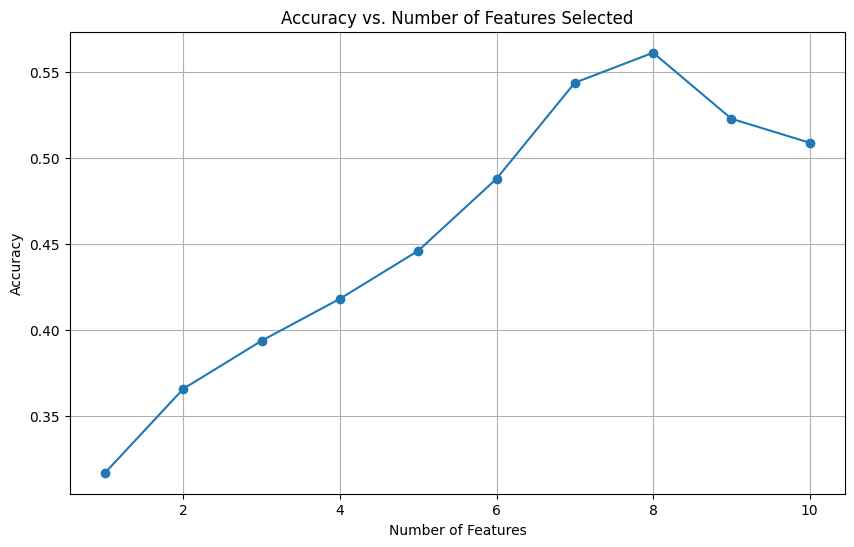

Top 10 feature indices: [ 0  4  7  9 10 12 15 17 19 20]


In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from deap import base, creator, tools

class QuantumGeneticAlgorithm:
    def __init__(self, population_size=50, generations=20, cxpb=0.1, mutpb=0.05):
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb
        self.mutpb = mutpb

    def evaluate(self, individual, X, y):
        indices = np.flatnonzero(individual)
        X_selected = X[:, indices]
        if X_selected.shape[1] == 0:
            return (0,)
        clf = SVC()
        clf.fit(X_selected, y)
        accuracy = clf.score(X_selected, y)
        return (accuracy,)

    def fit(self, X, y):
        num_features = X.shape[1]
        
        if "FitnessMax" in creator.__dict__:
            del creator.FitnessMax
        if "Individual" in creator.__dict__:
            del creator.Individual
        
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", np.random.randint, 2)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self.evaluate, X=X, y=y)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)
        
        population = toolbox.population(n=self.population_size)
        
        for generation in range(self.generations):
            offspring = toolbox.select(population, len(population))
            offspring = list(map(toolbox.clone, offspring))
            
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if np.random.random() < self.cxpb:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
            
            for mutant in offspring:
                if np.random.random() < self.mutpb:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values
            
            invalid_ind = [ind for ind in population if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            population[:] = offspring
        
        best_individual = tools.selBest(population, 1)[0]
        return best_individual

# Load your data
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']
y = data['labels']

# Convert complex values to real if necessary
X = np.real(X)

# Ensure y is a 1D array
y = np.ravel(y)

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initialize and run the Quantum Genetic Algorithm
qga = QuantumGeneticAlgorithm(population_size=50, generations=20, cxpb=0.1, mutpb=0.05)
best_individual = qga.fit(X, y)

# Extract selected features based on the best individual
selected_indices = np.flatnonzero(best_individual)

# If there are fewer than 10 selected features, use all of them
num_features_to_plot = min(10, len(selected_indices))

# Compute accuracy for varying numbers of selected features
accuracies = []
for i in range(1, num_features_to_plot + 1):
    current_indices = selected_indices[:i]
    X_selected = X[:, current_indices]
    clf = SVC()
    clf.fit(X_selected, y)
    accuracy = clf.score(X_selected, y)
    accuracies.append(accuracy)

# Plot the accuracy vs. number of features
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(range(1, num_features_to_plot + 1), accuracies, marker='o')
plt.title('Accuracy vs. Number of Features Selected')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('feature_selection_accuracy.png', dpi=300)  # Save with 300 DPI
plt.show()

# Display the top features
top_features_indices = selected_indices[:10]
print(f"Top 10 feature indices: {top_features_indices}")


In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from deap import base, creator, tools

class QuantumGeneticAlgorithm:
    def __init__(self, population_size=50, generations=20, cxpb=0.1, mutpb=0.05):
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb
        self.mutpb = mutpb

    def evaluate(self, individual, X, y):
        indices = np.flatnonzero(individual)
        X_selected = X[:, indices]
        if X_selected.shape[1] == 0:
            return (0,)
        clf = SVC()
        clf.fit(X_selected, y)
        accuracy = clf.score(X_selected, y)
        return (accuracy,)

    def fit(self, X, y):
        num_features = X.shape[1]
        
        if "FitnessMax" in creator.__dict__:
            del creator.FitnessMax
        if "Individual" in creator.__dict__:
            del creator.Individual
        
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", np.random.randint, 2)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self.evaluate, X=X, y=y)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)
        
        population = toolbox.population(n=self.population_size)
        
        for generation in range(self.generations):
            offspring = toolbox.select(population, len(population))
            offspring = list(map(toolbox.clone, offspring))
            
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if np.random.random() < self.cxpb:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
            
            for mutant in offspring:
                if np.random.random() < self.mutpb:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values
            
            invalid_ind = [ind for ind in population if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            population[:] = offspring
        
        best_individual = tools.selBest(population, 1)[0]
        return best_individual

# Load your data
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']
y = data['labels']

# Convert complex values to real if necessary
X = np.real(X)

# Ensure y is a 1D array
y = np.ravel(y)

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initialize and run the Quantum Genetic Algorithm
qga = QuantumGeneticAlgorithm(population_size=50, generations=20, cxpb=0.1, mutpb=0.05)
best_individual = qga.fit(X, y)

# Extract selected features based on the best individual
selected_indices = np.flatnonzero(best_individual)

# Select the top 20 features if available
num_features_to_use = min(20, len(selected_indices))
top_20_indices = selected_indices[:num_features_to_use]

# Compute accuracy with the top 20 features
X_selected = X[:, top_20_indices]
clf = SVC()
clf.fit(X_selected, y)
accuracy = clf.score(X_selected, y)

# Print accuracy
print(f"Accuracy using the top {num_features_to_use} features: {accuracy:.4f}")

# Display the top features
print(f"Top {num_features_to_use} feature indices: {top_20_indices}")


Accuracy using the top 20 features: 0.5261
Top 20 feature indices: [ 2  3  4  5  6  7 12 13 18 19 21 24 26 27 28 29 31 32 33 37]
